In [128]:
import h5py
import os
import numpy as np
import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.interpolate import NearestNDInterpolator
from utils import transform_coord
from utils import make_grid
from utils import mad_std
from utils import spatial_filter
from utils import interp2d
from utils import tiffread
from utils import binning
from scipy.ndimage.filters import generic_filter
from shutil import copyfile
import re
import pyproj
%matplotlib inline

In [101]:
datapath='/home/jovyan/shared/surface_velocity/FIS_ATL06_small/'
outputPath='/home/jovyan/shared/surface_velocity/FIS_ATL06_small_demeaned/'

In [ ]:
#!python readatl06.py /home/jovyan/shared/surface_velocity/FIS_ATL06_small/*.h5 -o /home/jovyan/shared/surface_velocity/FIS_processed_ATL06 -n 8

In [14]:
#!python merge.py /home/jovyan/shared/surface_velocity/FIS_ATL06_small_processed/*D.h5 -o /home/jovyan/shared/surface_velocity/FIS_ATL06_small_merged/FIS_ATL06_D.h5

In [15]:
#!python fittopo.py /home/jovyan/shared/surface_velocity/FIS_ATL06_small_merged/FIS_ATL06_D.h5 -d 1 1 -r 1.0 -q 3 -i 5 -z 10 -m 100 \
#-k 2 -t 2020 -j 3031 -v lon lat t_year h_elv -s 10 -p

In [16]:
#!python fittopo.py /home/jovyan/shared/surface_velocity/FIS_ATL06_small_merged/FIS_ATL06_A.h5 -d 1 1 -r 1.0 -q 3 -i 5 -z 10 -m 100 \
#-k 2 -t 2020 -j 3031 -v lon lat t_year h_elv -s 10 -p

In [13]:
##Merge the files.
#NB: For some reason, FIS_ATL06_D_TOPO.h5 does not have s_elv. What is that field?
#!python merge.py /home/jovyan/shared/surface_velocity/FIS_ATL06_small_merged/FIS_ATL06_?_TOPO.h5 -o /home/jovyan/shared/surface_velocity/FIS_ATL06_small_merged/FIS_ATL06_AD.h5

In [100]:
!h5ls /home/jovyan/shared/surface_velocity/FIS_ATL06_small/processed_ATL06_20190531193406_09700311_003_01.h5

METADATA                 Group
ancillary_data           Group
gt1l                     Group
gt1r                     Group
gt2l                     Group
gt2r                     Group
gt3l                     Group
gt3r                     Group
orbit_info               Group
quality_assessment       Group


In [27]:
FIS_data = h5py.File('/home/jovyan/shared/surface_velocity/FIS_ATL06_small_merged/FIS_ATL06_AD.h5','r')

In [29]:
print(FIS_data["cycle"][:])

[4. 4. 4. ... 7. 7. 7.]


Now let's dig into the merged file

In [23]:
with h5py.File('/home/jovyan/shared/surface_velocity/FIS_ATL06_small_merged/FIS_ATL06_AD.h5','r') as f_r:
    lat   = f_r['lat'][:]
    lon   = f_r['lon'][:]
    t_yrs = f_r['t_year'][:]
    h_res = f_r['h_res'][:]
    h_mod = f_r['h_mod'][:] # <---This is the static surface
    h_org = f_r['h_elv'][:]

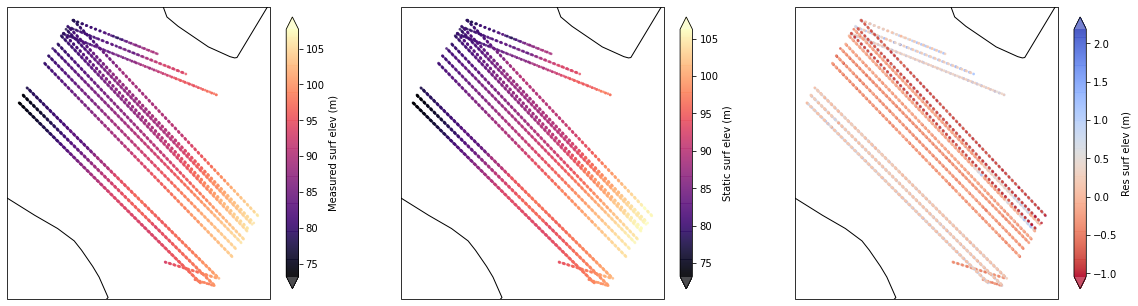

In [79]:
fig,ax = plt.subplots(ncols=3, figsize=(20,20), subplot_kw={'projection':ccrs.SouthPolarStereo()})

FIS_origSurfPlot = ax[0].scatter(lon[::100], lat[::100], s=3, c=h_org[::100], alpha=.7, transform=ccrs.PlateCarree(), cmap='magma')
cax0,kw0 = matplotlib.colorbar.make_axes(ax[0],location='right',pad=0.05,shrink=0.25, label='Measured surf elev (m)')
resCBar=fig.colorbar(FIS_origSurfPlot,cax=cax0,extend='both',**kw0)
ax[0].coastlines('50m')

FIS_statSurfPlot = ax[1].scatter(lon[::100], lat[::100], s=3, c=h_mod[::100], alpha=.7, transform=ccrs.PlateCarree(), cmap='magma')
cax1,kw1 = matplotlib.colorbar.make_axes(ax[1],location='right',pad=0.05,shrink=0.25, label='Static surf elev (m)')
statCBar=fig.colorbar(FIS_statSurfPlot,cax=cax1,extend='both',**kw1)
ax[1].coastlines('50m')

FIS_resSurfPlot = ax[2].scatter(lon[::100], lat[::100], s=3, c=h_res[::100], alpha=.7, transform=ccrs.PlateCarree(), cmap='coolwarm_r')
cax2,kw2 = matplotlib.colorbar.make_axes(ax[2],location='right',pad=0.05,shrink=0.25, label='Res surf elev (m)')
resCBar=fig.colorbar(FIS_resSurfPlot,cax=cax2,extend='both',**kw2)
ax[2].coastlines('50m')

plt.show()

Mean: 6.453 cm
Std.dev: 54.958 cm
Rejected: 0.0 %


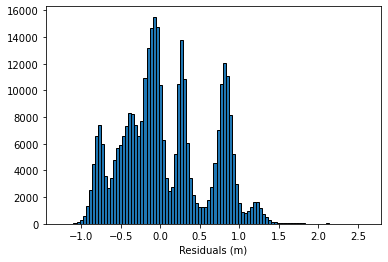

In [25]:
fig = plt.hist(h_res[~np.isnan(h_res)], 100, edgecolor='k')
plt.xlabel('Residuals (m)')
print('Mean:', np.around(100*np.nanmean(h_res),3), 'cm')
print('Std.dev:',np.around(100*np.nanstd(h_res),3), 'cm')
print('Rejected:', np.around(100*(float(len(h_res[np.isnan(h_res)]))/len(h_res)),2), '%')

## Create function to interpolate static surface

In [130]:
staticSurfInterpolator = NearestNDInterpolator(np.vstack((lon, lat)).T, h_mod) # interpolator function

## Loop through all files input into the merged dataset, subtract static surface, and save as new file.

In [161]:
beams = ['gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l', 'gt3r'] # loop through each beam
for file in os.listdir(datapath):
    print("Subtracting static surface from tracks in {}".format(file))
    destFile = file.replace('processed', 'demeaned')
    copyfile(datapath+'/'+file, outputPath+'/'+destFile) #make a copy of the file to append to in outputPath directory
    for beam in beams:
        try:
            print("Processing beam {}".format(beam))
            with h5py.File(datapath + '/' + file, 'r') as sourceFile:
                beamLat = sourceFile[beam+'/land_ice_segments/latitude'][:]
                beamLon = sourceFile[beam+'/land_ice_segments/longitude'][:]
                h_li_statSurf = staticSurfInterpolator(np.vstack((beamLon,beamLat)).T)
                h_li_res = sourceFile[beam+'/land_ice_segments/h_li'][:]- h_li_statSurf
            
            with h5py.File(outputPath + '/' + destFile, 'a') as demeanedFile:
                demeanedFile[beam+'/h_li_res'] = h_li_res
                demeanedFile[beam+'/h_li_statSurf'] = h_li_statSurf
        except:
            print("Data not found for beam {}. Skipping".format(beam))

Subtracting static surface from tracks in processed_ATL06_20190928135001_00250511_003_01.h5
Processing beam gt1l
Processing beam gt1r
Processing beam gt2l
Processing beam gt2r
Processing beam gt3l
Processing beam gt3r
Subtracting static surface from tracks in processed_ATL06_20200328050931_00250711_003_01.h5
Processing beam gt1l
Processing beam gt1r
Processing beam gt2l
Processing beam gt2r
Processing beam gt3l
Processing beam gt3r
Subtracting static surface from tracks in processed_ATL06_20191129105346_09700511_003_01.h5
Processing beam gt1l
Processing beam gt1r
Processing beam gt2l
Processing beam gt2r
Processing beam gt3l
Processing beam gt3r
Subtracting static surface from tracks in processed_ATL06_20191002134142_00860511_003_01.h5
Processing beam gt1l
Processing beam gt1r
Processing beam gt2l
Processing beam gt2r
Processing beam gt3l
Processing beam gt3r
Subtracting static surface from tracks in processed_ATL06_20190906042253_10700411_003_01.h5
Processing beam gt1l
Processing beam

## Plot all beams of one track up at random

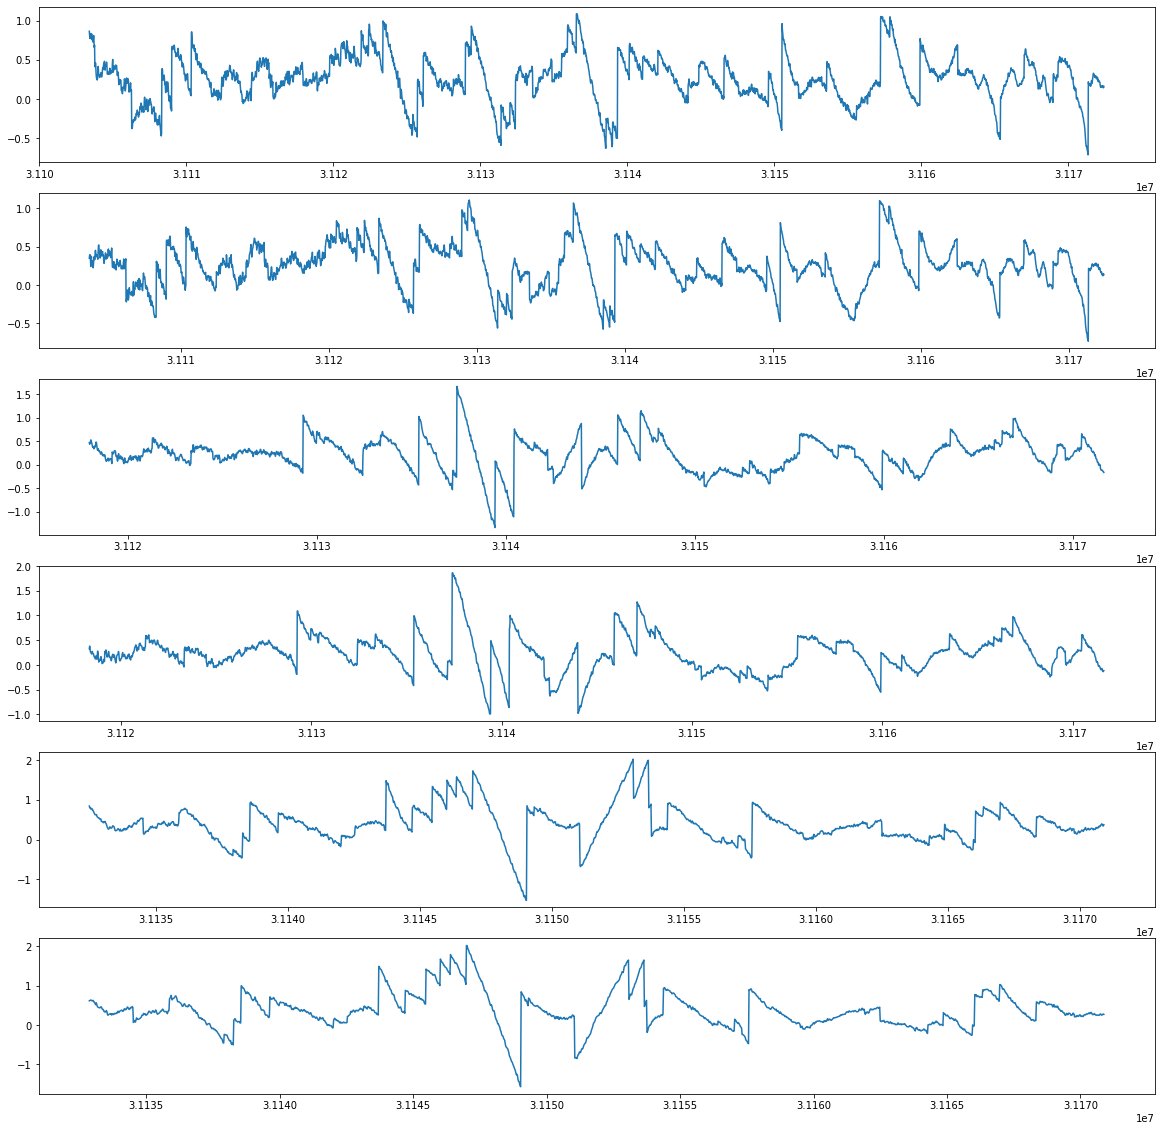

In [163]:
fig, ax = plt.subplots(6,1, figsize=(20,20))
beamCount=0
plotFilePath='/home/jovyan/shared/surface_velocity/FIS_ATL06_small_demeaned/demeaned_ATL06_20191206000243_10700511_003_01.h5'

with h5py.File(plotFilePath, 'r') as afile:
    for beam in beams:
        h_li_res = afile[beam+'/h_li_res'][:]
        x_atc = afile[beam+'/land_ice_segments/ground_track/x_atc/'][:]
        ax[beamCount].plot(x_atc, h_li_res)
        beamCount += 1
        
        
plt.show()